#### Blogging Material why Pipeline is important?
- Basic regression
- Basic classification
- Basic clustering

In [1]:
# Common imports
import numpy as np
import pandas as pd 
import os
# to make this notebook's output stable across runs
np.random.seed(42)
# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

In [2]:
# Getting the library for packaging in: 
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import OneHotEncoder, StandardScaler,OrdinalEncoder, FunctionTransformer 
from sklearn.impute import SimpleImputer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.svm import SVR 
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV , StratifiedShuffleSplit , train_test_split
from scipy.stats import randint ,  expon, reciprocal
# since Scikit-Learn doesn't handle DataFrames yet
class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names]
# Inspired from stackoverflow.com/questions/25239958
class MostFrequentImputer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        self.most_frequent_ = pd.Series([X[c].value_counts().index[0] for c in X],
                                        index=X.columns)
        return self
    def transform(self, X, y=None):
        return X.fillna(self.most_frequent_)

#### A basic pipeline for almost any basic first draft prediction - perfect for baseline
- 1) Select data: 
- 2) Seperate numerical and categorical data:
    - Perform rough cleaning 
    - Perform rough scaling
    - Perform basic data attending
- 3) Run the Models:
- 4) Freedom to gridrun:

In [3]:
df = pd.read_csv('D:\\William\\Github\\2022 - Re-organised\\HandsOn ML SciKitLearn Tensorflow\\datasets\\auto-mpg.csv')
df['horsepower'] = pd.to_numeric(df['horsepower'],errors='coerce')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 398 entries, 0 to 397
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   mpg           398 non-null    float64
 1   cylinders     398 non-null    int64  
 2   displacement  398 non-null    float64
 3   horsepower    392 non-null    float64
 4   weight        398 non-null    int64  
 5   acceleration  398 non-null    float64
 6   model year    398 non-null    int64  
 7   origin        398 non-null    int64  
 8   car name      398 non-null    object 
 9   Unnamed: 9    0 non-null      float64
 10  Unnamed: 10   0 non-null      float64
 11  Unnamed: 11   0 non-null      float64
 12  Unnamed: 12   0 non-null      float64
 13  Unnamed: 13   0 non-null      float64
dtypes: float64(9), int64(4), object(1)
memory usage: 43.7+ KB


In [4]:
df.drop(['car name','Unnamed: 9','Unnamed: 10', 'Unnamed: 11', 'Unnamed: 12', 'Unnamed: 13'], axis =1, inplace=True)
df.columns

Index(['mpg', 'cylinders', 'displacement', 'horsepower', 'weight',
       'acceleration', 'model year', 'origin'],
      dtype='object')

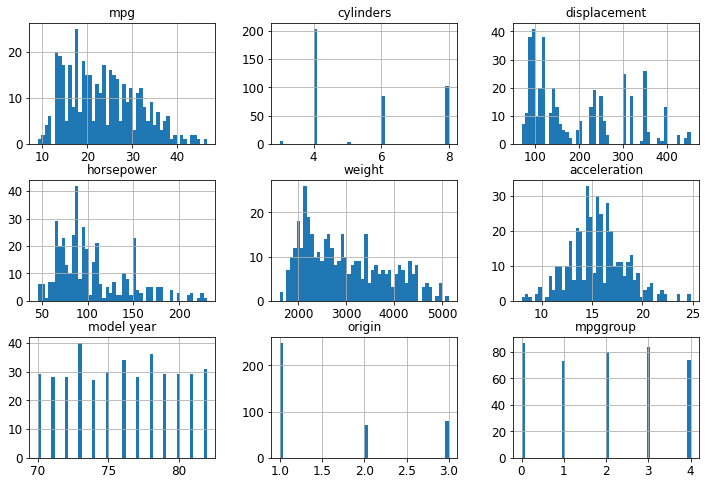

mpg             1.000000
mpggroup        0.957023
model year      0.579267
origin          0.563450
acceleration    0.420289
cylinders      -0.775396
horsepower     -0.778427
displacement   -0.804203
weight         -0.831741
Name: mpg, dtype: float64


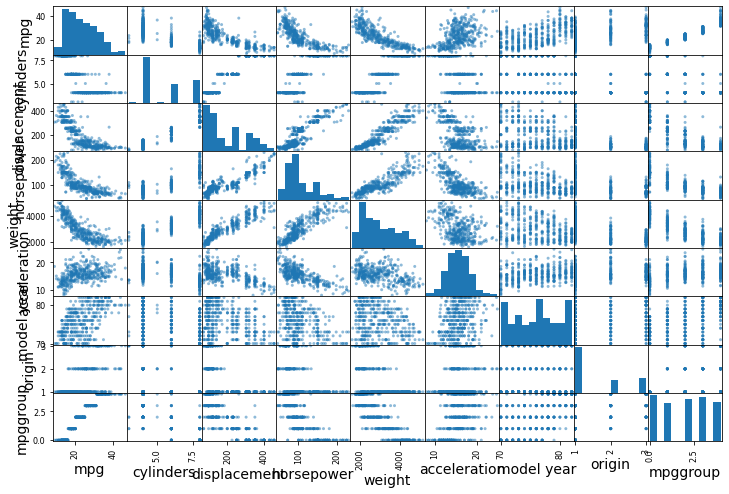

              count         mean         std     min       25%     50%  \
mpg           398.0    23.514573    7.815984     9.0    17.500    23.0   
cylinders     398.0     5.454774    1.701004     3.0     4.000     4.0   
displacement  398.0   193.425879  104.269838    68.0   104.250   148.5   
horsepower    392.0   104.469388   38.491160    46.0    75.000    93.5   
weight        398.0  2970.424623  846.841774  1613.0  2223.750  2803.5   
acceleration  398.0    15.568090    2.757689     8.0    13.825    15.5   
model year    398.0    76.010050    3.697627    70.0    73.000    76.0   
origin        398.0     1.572864    0.802055     1.0     1.000     1.0   
mpggroup      398.0     1.962312    1.419932     0.0     1.000     2.0   

                   75%     max  
mpg             29.000    46.6  
cylinders        8.000     8.0  
displacement   262.000   455.0  
horsepower     126.000   230.0  
weight        3608.000  5140.0  
acceleration    17.175    24.8  
model year      79.000    82

In [5]:
def dfanalysis(df,targetvar): 
    from pandas.plotting import scatter_matrix
    df['mpggroup'] = pd.qcut(df[targetvar], 5, labels=False )
    df.hist(bins=50, figsize=(12, 8))
    plt.show()
    print(df.corr()[targetvar].sort_values(ascending=False))
    scatter_matrix(df, figsize = (12,8))
    plt.show()
    describe = df.describe(include='all').transpose()
    print(describe)
    return df , describe
df, describe  =dfanalysis(df,'mpg')

In [6]:
# 1 Select Data - avoid human stratified bias : 
def StratifiedShuffleSplitsplitdata(dataframe, targetvar): 
    split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
    for train_index, test_index in split.split(dataframe, dataframe[targetvar]):
        strat_train_set = dataframe.loc[train_index]
        strat_test_set = dataframe.loc[test_index]
        for set_ in (strat_train_set , strat_test_set):
            set_.drop('mpggroup',axis=1,inplace=True)
        return strat_train_set , strat_test_set
strat_train_set, strat_test_set = StratifiedShuffleSplitsplitdata(df, 'mpggroup')

In [7]:
strat_train_set.head()
strat_test_set.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,model year,origin
392,27.0,4,151.0,90.0,2950,17.3,82,1
147,24.0,4,90.0,75.0,2108,15.5,74,2
76,18.0,4,121.0,112.0,2933,14.5,72,2
362,24.2,6,146.0,120.0,2930,13.8,81,3
143,26.0,4,97.0,78.0,2300,14.5,74,2


In [8]:
num_attribs = list(['displacement','horsepower','weight','acceleration'])
cat_attribs = list(['cylinders','origin'])
target = strat_train_set['mpg']

In [9]:
# 2a numerical data
num_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy="median")),
        ('std_scaler', StandardScaler()),
    ])
# 2b categorical data
cat_pipeline = Pipeline([
        ("imputer", MostFrequentImputer()),
        ("cat_encoder", OneHotEncoder(sparse=False)),
    ])
full_pipeline = ColumnTransformer([
        ("num", num_pipeline, num_attribs),
        ("cat", cat_pipeline, cat_attribs),
    ])
full_pipeline_with_RFR = Pipeline([
        ("preparation", full_pipeline),
        ("RandomForestRegressor", RandomForestRegressor())
    ])
full_pipeline_with_SVM = Pipeline([
        ("preparation", full_pipeline),
        ("SVR", SVR() )
    ])
full_pipeline_with_SVMlin = Pipeline([
        ("preparation", full_pipeline),
        ("SVM", SVR(kernel='linear') )
    ])
full_pipeline_with_SVMrbf = Pipeline([
        ("preparation", full_pipeline),
        ("SVM", SVR(kernel='rbf') )
    ])
full_pipeline_with_linreg = Pipeline([
        ("preparation", full_pipeline),
        ("lin_reg", LinearRegression() )
    ])

In [10]:
#3 Run and analysis model
def evaluatepred(model,train,trainy,test,testy,modelname):
    model.fit(train, trainy)
    housing_predictions = model.predict(test)
    mdl_mse = mean_squared_error(test[testy], housing_predictions)
    mdl_rmse = np.sqrt(mdl_mse)
    print(str(model))
    print("RMSE: for ", str(modelname), " ", mdl_rmse)
    mdl_mae = mean_absolute_error(test[testy], housing_predictions)
    print("MAE: for ", str(modelname), " ", mdl_mae)

In [11]:
models = [full_pipeline_with_linreg,full_pipeline_with_SVMlin,full_pipeline_with_SVMrbf,full_pipeline_with_RFR]
modelnames = ['LinearRegressions', 'SVMlinear','SVMrbf','RandomForestRegressor']
for n,i in enumerate(models):
    evaluatepred(models[n],strat_train_set,target,strat_test_set,'mpg',modelnames[n])

Pipeline(steps=[('preparation',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('std_scaler',
                                                                   StandardScaler())]),
                                                  ['displacement', 'horsepower',
                                                   'weight', 'acceleration']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   MostFrequentImputer()),
                                                                  ('cat_encoder',
                                                                   OneHotEncoder(sparse=False)

In [ ]:
# 4 Gridrunning! 
# Note that it is taking time to run and so best to seperate. 
x_train_prep = full_pipeline.fit_transform(strat_train_set)
x_test_prep = full_pipeline.transform(strat_test_set)
# Note: gamma is ignored when kernel is "linear"
param_distribs = {
        'kernel': ['linear', 'rbf'],
        'C': reciprocal(20, 200000),
        'gamma': expon(scale=1.0),
    }
svm_reg = SVR()
# https://stackoverflow.com/questions/68811073/check-the-list-of-available-parameters-with-estimator-get-params-keys
rnd_search = RandomizedSearchCV(svm_reg , param_distributions=param_distribs,
                                n_iter=50, cv=5, scoring='neg_mean_squared_error',
                                verbose=2, n_jobs=-1, random_state=42)
rnd_search.fit(x_train_prep, target)
negative_mse = grid_search.best_score_
rmse = np.sqrt(-negative_mse)
rmse

Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    8.0s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  5.8min


In [ ]:
print("Best parameter (CV score=%0.3f):" % rnd_search.best_score_)
print(rnd_search.best_params_)

In [ ]:
param_grid = [
        {'kernel': ['linear'], 'C': [10., 30., 100., 300., 1000., 3000., 10000., 30000.0]},
        {'kernel': ['rbf'], 'C': [1.0, 3.0, 10., 30., 100., 300., 1000.0],
         'gamma': [0.01, 0.03, 0.1, 0.3, 1.0, 3.0]},
    ]
grid_search = GridSearchCV(model , param_grid, cv = 5 , scoring='neg_mean_squared_error', verbose=2, n_jobs=4)
grid_search.fit(strat_train_set, target)
negative_mse = grid_search.best_score_
rmse = np.sqrt(-negative_mse)
rmse

*** Get some data for regression but doesn't really matter ***

In [ ]:
# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "end_to_end_project"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)

# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")
# Get the data
import tarfile
from six.moves import urllib

DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml/master/"
HOUSING_PATH = os.path.join("datasets", "housing")
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"

def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    if not os.path.isdir(housing_path):
        os.makedirs(housing_path)
    tgz_path = os.path.join(housing_path, "housing.tgz")
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()
    
fetch_housing_data()

def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)
housing = load_housing_data()
housing.sample(3)

In [ ]:
#Now let's build a pipeline for preprocessing the numerical attributes (note that we could use CombinedAttributesAdder() instead of  FunctionTransformer(...) if we preferred):

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import FunctionTransformer
from sklearn.impute import SimpleImputer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.svm import SVR 
from sklearn.ensemble import RandomForestRegressor
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint ,  expon, reciprocal
# Split by key driver -> median Income Category 
from sklearn.model_selection import StratifiedShuffleSplit
# Divide by 1.5 to limit the number of income categories
housing["income_cat"] = np.ceil(housing["median_income"] / 1.5)
# Label those above 5 as 5
housing["income_cat"].where(housing["income_cat"] < 5, 5.0, inplace=True)
housing["income_cat"].value_counts().sort_index()
housing["income_cat"].hist()
for train_index, test_index in StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42).split(housing, housing["income_cat"]):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]
(strat_test_set["income_cat"].value_counts() / len(strat_test_set)).sort_index()
housing = strat_train_set.drop(["median_house_value","income_cat" ], axis=1)

housing_labels = strat_train_set["median_house_value"].copy()
housing_num = housing.drop('ocean_proximity', axis=1)
print(housing_num.columns)

num_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy="median")),
        ('std_scaler', StandardScaler()),
    ])

housing_num_tr = num_pipeline.fit_transform(housing_num)
num_attribs = list(housing_num)
cat_attribs = ["ocean_proximity"]
full_pipeline = ColumnTransformer([
        ("num", num_pipeline, num_attribs),
        ("cat", OneHotEncoder(), cat_attribs),
    ])
housing_prepared = full_pipeline.fit_transform(housing)
print(housing_prepared.shape)
housing_prepared


In [ ]:
# Get Top Attributes:
param_grid = [
    {'n_estimators' : [3, 10 ,30], 'max_features': [2,4,6,8]},
    {'bootstrap':[False],'n_estimators' : [3, 10],'max_features': [2,3,4]},
]
param_distribs = {
        'n_estimators': randint(low=1, high=200),
        'max_features': randint(low=1, high=8),
    }
forest_reg = RandomForestRegressor()
rnd_search = RandomizedSearchCV(forest_reg, param_distributions=param_distribs,
                                n_iter=10, cv=5, scoring='neg_mean_squared_error', random_state=42)
rnd_search.fit(housing_prepared, housing_labels)

print(rnd_search.best_params_)
print(rnd_search.best_estimator_)
cvres2 = rnd_search.cv_results_
for mean_score, params in zip(cvres2['mean_test_score'] , cvres2['params']):
    print(np.sqrt(-mean_score), params)

In [ ]:
negative_mse = rnd_search.best_score_
rmse = np.sqrt(-negative_mse)
print(rmse)
rnd_search.best_params_

In [ ]:
expon_distrib = expon(scale=1.)
samples = expon_distrib.rvs(10000, random_state=42)
plt.figure(figsize=(10, 4))
plt.subplot(121)
plt.title("Exponential distribution (scale=1.0)")
plt.hist(samples, bins=50)
plt.subplot(122)
plt.title("Log of this distribution")
plt.hist(np.log(samples), bins=50)
plt.show()

In [ ]:
reciprocal_distrib = reciprocal(20, 200000)
samples = reciprocal_distrib.rvs(10000, random_state=42)
plt.figure(figsize=(10, 4))
plt.subplot(121)
plt.title("Reciprocal distribution (scale=1.0)")
plt.hist(samples, bins=50)
plt.subplot(122)
plt.title("Log of this distribution")
plt.hist(np.log(samples), bins=50)
plt.show()